# Sales Analysis

## Definitions

**Total Revenue** - Total revenue in sales including the tax revenue. This is the total amount of money coming in including tax and without subtracting costs. This amounts to the sum of each sales transaction expressed as `Price * Quantity + State Tax`. Note `State Tax` is `(Price * Quantity) * State Tax Rate`, so combining the two expressions, Total Revenue could be described as `Price * Quantity * (1 + State Tax Rate)`

**Gross Profit** - Total profit in sales after subtracting tax revenue and subtracting product costs. This amounts to the sum of each sales transaction `( (Price - Cost) * Quantity) )`.

**Net Profit** - Total profit in sales after subtracting additional business expenses. This is the total amount of money left after subtracting all costs. This amounts to the expression `Gross Profit for a Given Period - All Additional Business Expenses for a Given Period`.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
customers = pd.read_csv('https://cs.indstate.edu/~lmay1/assets/sales-data/customers.csv', header=0).to_dict('records')
expenses = pd.read_csv('https://cs.indstate.edu/~lmay1/assets/sales-data/expenses.csv', header=0).to_dict('records')
products = pd.read_csv('https://cs.indstate.edu/~lmay1/assets/sales-data/products.csv', header=0).to_dict('records')
taxes = pd.read_csv('https://cs.indstate.edu/~lmay1/assets/sales-data/tax.csv', header=0).to_dict('records')
monthly_sales = []

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
#Dictionary credit to https://gist.github.com/rogerallen/1583593

for i in range(1, 13):
    number = str(i).zfill(2)
    monthly_sales.append(pd.read_csv(f'https://cs.indstate.edu/~lmay1/assets/sales-data/sales-{number}.csv', header=0).to_dict('records'))

# Customer Data Stats - Bad Data

In [10]:
total, misfirst, mislast, miszip, misstate, swapzipstate = 0, 0, 0, 0, 0, 0
for customer in customers:
    
    #use var total to keep track of total customers
    total += 1
    
    #Find all the 'correct' first names, subtract this amount from total to get incorrect name fields
    if(type(customer['FirstName']) == str):
        if(len(customer['FirstName']) > 0):
            misfirst += 1
            
    #Find all the 'correct' last names, subtract this amount from total to get incorrect name fields
    if(type(customer['LastName']) == str):
        if(len(customer['LastName']) > 0):
            mislast += 1
        
    #Find all the 'correct' zip codes, subtract this amount from total to get incorrect name fields
    if(type(customer['Zip']) == str):
        if(len(customer['Zip']) == 5):
            miszip += 1
    
    #Find all the 'correct' states, subtract this amount from total to get incorrect name fields
    if(type(customer['State']) == str):
        if(len(customer['State']) == 2):
            misstate += 1

    if(type(customer['State']) == str and type(customer['Zip']) == str):        
        if( len(customer["State"]) == 5 and len(customer["Zip"]) == 2 ):
            swapzipstate += 1

#Subtract all values from total to get number of missing values, and divide by total for percentages
misfirst = 100 * (total - misfirst) / total
mislast = 100 * (total - mislast) / total
miszip = 100 * (total - miszip) / total
misstate = 100 * (total - misstate) / total
swapzipstate /= total
swapzipstate *= 100



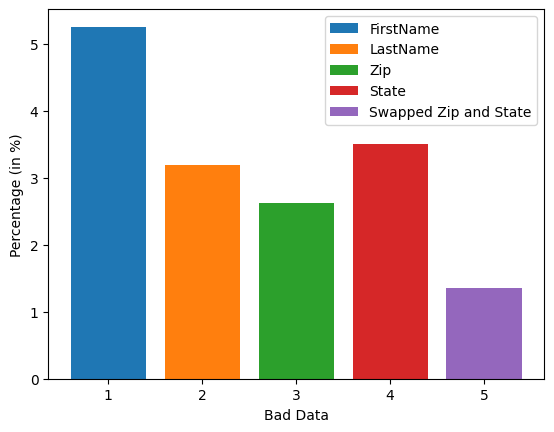

In [11]:
plt.bar(1, misfirst, label="FirstName")
plt.bar(2, mislast, label="LastName")
plt.bar(3, miszip, label="Zip")
plt.bar(4, misstate, label="State")
plt.bar(5, swapzipstate, label="Swapped Zip and State")

plt.xlabel("Bad Data")
plt.ylabel("Percentage (in %)")
plt.legend(loc=0)

plt.show()

# `Total Revenue`, `Gross Profit`, and `Net Profit`

## `Total Revenue`

In [12]:
totalrev = []
statetax, customertax, prodprices = {}, {}, {}
indexedSales = []

for product in products:
    prodprices.update({ product['ProductId'] : product['Price'] })

# Initialize lists of monthly revenues, gross profits, and net profits (month corresponds to list index)
for i in range(12):
    totalrev.append(0)
    indexedSales.append([])

# Create a dictionary that allows for easier access of state tax rates from customerId's
for item in taxes:
    key = item['State']
    rate = item['Rate']
    if( type(rate) == float):
        statetax.update({us_state_to_abbrev[key] : 1})
    else:
        newrate = (float(rate[:-1])+100) / 100
        statetax.update({us_state_to_abbrev[key] : newrate})

# Following the same idea as the previous loop, create a dict with format {customerId : state tax rate} for easier calculations later
for i in customers:
    state = i['State']
    if(type(state) == str):
        if(len(state) == 2):
            customertax.update({i['CustomerId'] : statetax[state]})

        
# Go through all the sales and get only the data needed, which will be converted (customerId, product, quantity sold)
for i in range(12):
    for sale in monthly_sales[i]:
        customer = sale['CustomerId']
        product = sale['ProductId']
        quantity = sale['Quantity']
        indexedSales[i].append(tuple((customer, product, quantity)))

# Iterate through newly formatted sales and convert them to revenue, and store in correct month index
for month in range(12):
    for sale in indexedSales[month]:
        custid = sale[0]
        itemid = sale[1]
        quantity = sale[2]
        print(sale)
        
        if(customertax.get(custid) != None):
            tax = customertax[custid]
        price = prodprices[itemid]

        saletotal = (price * quantity) * tax
        totalrev[month] += saletotal

(1699, 'Fidget', 16)
(1699, 'Fidget', 4)
(2001, 'Fidget', 6)
(2001, 'Bauble', 1)
(2001, 'Gadget', 13)
(2001, 'Doodad', 17)
(2141, 'Widget', 3)
(2141, 'Doodad', 10)
(2141, 'Trinket', 1)
(1317, 'Widget', 12)
(1967, 'Widget', 19)
(1967, 'Gadget', 18)
(1967, 'Gadget', 10)
(1813, 'Doodad', 8)
(1813, 'Trinket', 15)
(1813, 'Fidget', 18)
(1813, 'Trinket', 5)
(1813, 'Gizmo', 8)
(1813, 'Widget', 15)
(1435, 'Doodad', 10)
(1820, 'Trinket', 4)
(1820, 'Doodad', 18)
(1820, 'Fidget', 17)
(1820, 'Bauble', 5)
(1820, 'Bauble', 4)
(1820, 'Gewgaw', 4)
(1820, 'Fidget', 8)
(1820, 'Gadget', 18)
(1945, 'Bauble', 13)
(1945, 'Bauble', 17)
(1945, 'Gadget', 11)
(1945, 'Gadget', 5)
(1945, 'Gewgaw', 18)
(1945, 'Gadget', 17)
(1945, 'Trinket', 12)
(2244, 'Trinket', 15)
(2244, 'Gizmo', 2)
(2244, 'Widget', 16)
(2244, 'Gizmo', 17)
(2244, 'Bauble', 9)
(2244, 'Gadget', 1)
(2244, 'Trinket', 3)
(2244, 'Doodad', 14)
(2244, 'Trinket', 19)
(1126, 'Trinket', 18)
(1126, 'Widget', 5)
(1126, 'Gizmo', 11)
(1126, 'Doodad', 2)
(1797, 

(1097, 'Doodad', 15)
(1097, 'Fidget', 1)
(1097, 'Bauble', 9)
(1097, 'Trinket', 15)
(1097, 'Fidget', 9)
(1097, 'Doodad', 3)
(1045, 'Widget', 14)
(1045, 'Widget', 19)
(1658, 'Gadget', 6)
(1658, 'Trinket', 4)
(1658, 'Widget', 4)
(1658, 'Doodad', 17)
(1658, 'Bauble', 10)
(2178, 'Gizmo', 9)
(2178, 'Gizmo', 1)
(2178, 'Gizmo', 2)
(2178, 'Gizmo', 6)
(1506, 'Gizmo', 8)
(1506, 'Gewgaw', 19)
(1506, 'Bauble', 16)
(1506, 'Doodad', 6)
(1506, 'Bauble', 7)
(1506, 'Fidget', 11)
(1506, 'Trinket', 8)
(1506, 'Doodad', 16)
(1506, 'Gizmo', 11)
(1742, 'Gadget', 9)
(1742, 'Gadget', 14)
(1742, 'Doodad', 1)
(1742, 'Gadget', 12)
(1742, 'Widget', 7)
(2086, 'Doodad', 7)
(2086, 'Gewgaw', 14)
(2086, 'Gadget', 10)
(2086, 'Bauble', 10)
(2086, 'Bauble', 2)
(2086, 'Gadget', 15)
(2086, 'Gizmo', 17)
(1241, 'Gizmo', 3)
(1241, 'Gizmo', 11)
(1241, 'Gadget', 18)
(2016, 'Bauble', 9)
(2016, 'Doodad', 15)
(2016, 'Trinket', 6)
(1200, 'Fidget', 18)
(1200, 'Doodad', 19)
(1200, 'Widget', 9)
(1200, 'Gewgaw', 11)
(1200, 'Gizmo', 1)
(1

## `Gross Profit` and `Net Profit`

In [13]:
grossprof, netprof, monthlyexpenses = [], [], []
prodprofs = {}

# Initialize montly profits to 0
for i in range(12):
    grossprof.append(0)
    netprof.append(0)

# Create list of expenses each month, where indicies indicate month (i.e. 0 = january, 1 = february, etc.)
for i in expenses:
    monthlyexpenses.append(i['Expenses'])

# Create dictionary of products and their profit margins
for product in products:
    prodprofs.update({ product['ProductId'] : tuple((product['Price'] - product['Cost'], 0 )) })

for i in range(12):
    
    # Reset quantities to 0 at start of each month
    for product in products:
        prodprofs.update({ product['ProductId'] : tuple((product['Price'] - product['Cost'], 0 )) })

    # Add up quanties for each item for the current month
    for sale in monthly_sales[i]:
        product = sale['ProductId']
        quantity = sale['Quantity']
        price = prodprofs[product][0]
        formquan = prodprofs[product][1]
        
        prodprofs.update({ product : tuple((price, formquan + quantity)) })
    
    # Update gross profit for current month
    for j in prodprofs.values():
        grossprof[i] += j[0] * j[1]
    
    # Get net profit for each month
    for month in range(12):
        netprof[month] = grossprof[month] - monthlyexpenses[i]

# Get min and max amounts of net profit for graphing
max = tuple((0, 0))
min = tuple((1, netprof[0]))
for i in range(len(netprof)):
    if(netprof[i] > max[1]): max = tuple(( i, netprof[i]))
    if(netprof[i] < min[1]): min = tuple(( i, netprof[i]))

# Plotting the Data

Text(0, 20, 'Max')

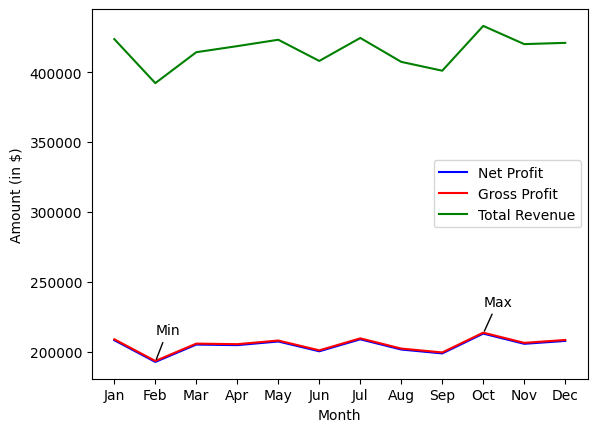

In [14]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep','Oct','Nov','Dec']
plt.plot(months, netprof, c='b', label='Net Profit')
plt.plot(months, grossprof, c='r', label='Gross Profit')
plt.plot(months, totalrev, c='g', label='Total Revenue')

plt.legend(loc=0)
plt.xlabel("Month")
plt.ylabel("Amount (in $)")

plt.annotate("Min",
            xy=(min[0], min[1]), xycoords='data',
            xytext=(0, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="-", color='black')
            )

plt.annotate("Max",
            xy=(max[0], max[1]), xycoords='data',
            xytext=(0, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="-", color='black')
            )

# Annual Sales Data - `Total Revenue` and `Gross Profit`

In [15]:
totalprodrev, grossprodprof = {}, {}

# Initialize gross profits and revenues for each product
for product in products:
    totalprodrev.update({ product['ProductId'] : 0 })
    grossprodprof.update({ product['ProductId'] : 0 })

# Iterate through all sales
for month in range(12):
    for sale in indexedSales[month]:
        # Grab some data from the sale
        custid = sale[0]
        itemid = sale[1]
        quantity = sale[2]
        
        if(customertax.get(custid) != None):
            tax = customertax[custid]
        price = prodprices[itemid]
        saletotal = (price * quantity) * tax
        
        # Add the revenues and gross profits of each sale to their corresponding items
        totalprodrev[itemid] += saletotal
        grossprodprof[itemid] += prodprofs[itemid][0] * quantity


# Plotting The Data

C:\Users\Wyatt\AppData\Local\Temp\ipykernel_844\3949559646.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(5, 623561.7596025034, 'Worst Seller: Trinket\nGross Profit: $120,162.84')

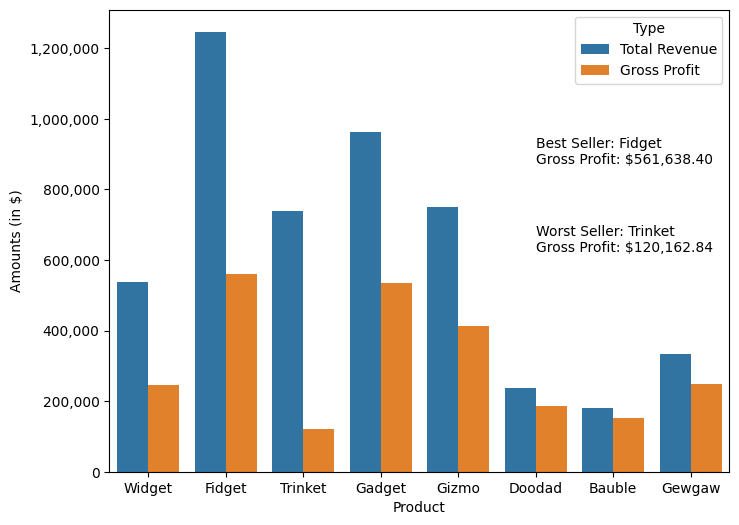

In [122]:
import seaborn as sns

prodnames, amounts, revorprof = [], [], []
for i in totalprodrev.items():
    prodnames.append(i[0])
    amounts.append(i[1])
    revorprof.append("Total Revenue")
    
for i in grossprodprof.items():
    amounts.append(i[1])
    revorprof.append("Gross Profit")
    max = (i[0], i[1])
    min = (i[0], i[1])
   
chartmax = np.max(np.array(amounts))


for i in grossprodprof.items():
    if(i[1] > max[1]): max = tuple(( i[0], i[1] ))
    if(i[1] < min[1]): min = tuple(( i[0], i[1] ))

for i in totalprodrev.items():
    prodnames.append(i[0])
    

df = pd.DataFrame({"Product":prodnames, "Amounts (in $)":amounts, "Type":revorprof})

plt.figure(figsize=(8, 6))
chart = sns.barplot(x="Product",y="Amounts (in $)", hue="Type", data=df)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

maxamount = '${:,.2f}'.format(max[1])
maxtext = "Best Seller: " + max[0] + "\nGross Profit: " + maxamount

minamount = '${:,.2f}'.format(min[1])
mintext = "Worst Seller: " + min[0] + "\nGross Profit: " + minamount

chart.text(len(products)-3, chartmax*.7, maxtext)
chart.text(len(products)-3, chartmax*.5, mintext)
